# **Искусственные нейронные сети: первые шаги**

# Базовая нейросеть

In [1]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report

# Загрузка и разбиение данных
X, y = load_iris(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Модель MLP — многослойный перцептрон
clf = MLPClassifier(hidden_layer_sizes=(10,), activation='relu', max_iter=500)
clf.fit(X_train, y_train)

# Отчёт о точности
print(classification_report(y_test, clf.predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        11
           1       1.00      0.75      0.86         8
           2       0.85      1.00      0.92        11

    accuracy                           0.93        30
   macro avg       0.95      0.92      0.92        30
weighted avg       0.94      0.93      0.93        30



D:\Практика. 2 курс\Task 4\venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


In [4]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report

# Загрузка и разбиение данных
X, y = load_iris(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Модель MLP — многослойный перцептрон
clf = MLPClassifier(hidden_layer_sizes=(10,), activation='relu', max_iter=100)
clf.fit(X_train, y_train)

# Отчёт о точности
print(classification_report(y_test, clf.predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       0.00      0.00      0.00        12
           2       0.43      0.90      0.58        10

    accuracy                           0.57        30
   macro avg       0.48      0.63      0.53        30
weighted avg       0.41      0.57      0.46        30



D:\Практика. 2 курс\Task 4\venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


In [5]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report

# Загрузка и разбиение данных
X, y = load_iris(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Модель MLP — многослойный перцептрон
clf = MLPClassifier(hidden_layer_sizes=(10,), activation='relu', max_iter=2500)
clf.fit(X_train, y_train)

# Отчёт о точности
print(classification_report(y_test, clf.predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        13
           1       1.00      1.00      1.00        11
           2       1.00      1.00      1.00         6

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



# Самостоятельное задание

# Biclustering документов с алгоритмом Spectral Co-clustering

## Цель задачи:
Целью данной работы является демонстрация применения алгоритма Spectral Co-clustering для совместной кластеризации документов и слов (бикластеризации) на наборе данных 20 newsgroups. 

Бикластеризация позволяет находить подмножества слов, которые часто встречаются вместе в подмножествах документов, что полезно для тематического моделирования и анализа текстов.

Алгоритм сравнивается с MiniBatchKMeans по метрике V-measure.

## Импорт необходимых библиотек

In [1]:
from collections import Counter
from time import time
import numpy as np
from sklearn.cluster import MiniBatchKMeans, SpectralCoclustering
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.cluster import v_measure_score
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.datasets import make_biclusters
from sklearn.metrics import consensus_score

## 1. Работа с встроенным датасетом (20 newsgroups)

### 1.1 Загрузка и подготовка данных
Используем встроенный датасет 20 newsgroups, исключая категорию 'comp.os.ms-windows.misc', так как она содержит много постов только с данными.

In [19]:
# Authors: The scikit-learn developers
# SPDX-License-Identifier: BSD-3-Clause
from collections import Counter
from time import time

import numpy as np

from sklearn.cluster import MiniBatchKMeans, SpectralCoclustering
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.cluster import v_measure_score


def number_normalizer(tokens):
    """Map all numeric tokens to a placeholder.

    For many applications, tokens that begin with a number are not directly
    useful, but the fact that such a token exists can be relevant.  By applying
    this form of dimensionality reduction, some methods may perform better.
    """
    return ("#NUMBER" if token[0].isdigit() else token for token in tokens)


class NumberNormalizingVectorizer(TfidfVectorizer):
    def build_tokenizer(self):
        tokenize = super().build_tokenizer()
        return lambda doc: list(number_normalizer(tokenize(doc)))


# exclude 'comp.os.ms-windows.misc'
categories = [
    "alt.atheism",
    "comp.graphics",
    "comp.sys.ibm.pc.hardware",
    "comp.sys.mac.hardware",
    "comp.windows.x",
    "misc.forsale",
    "rec.autos",
    "rec.motorcycles",
    "rec.sport.baseball",
    "rec.sport.hockey",
    "sci.crypt",
    "sci.electronics",
    "sci.med",
    "sci.space",
    "soc.religion.christian",
    "talk.politics.guns",
    "talk.politics.mideast",
    "talk.politics.misc",
    "talk.religion.misc",
]
newsgroups = fetch_20newsgroups(categories=categories)
y_true = newsgroups.target

vectorizer = NumberNormalizingVectorizer(stop_words="english", min_df=5)
cocluster = SpectralCoclustering(
    n_clusters=len(categories), svd_method="arpack", random_state=0
)
kmeans = MiniBatchKMeans(
    n_clusters=len(categories), batch_size=20000, random_state=0, n_init=3
)

print("Vectorizing...")
X = vectorizer.fit_transform(newsgroups.data)

print("Coclustering...")
start_time = time()
cocluster.fit(X)
y_cocluster = cocluster.row_labels_
print(
    f"Done in {time() - start_time:.2f}s. V-measure: \
{v_measure_score(y_cocluster, y_true):.4f}"
)


print("MiniBatchKMeans...")
start_time = time()
y_kmeans = kmeans.fit_predict(X)
print(
    f"Done in {time() - start_time:.2f}s. V-measure: \
{v_measure_score(y_kmeans, y_true):.4f}"
)


feature_names = vectorizer.get_feature_names_out()
document_names = list(newsgroups.target_names[i] for i in newsgroups.target)


def bicluster_ncut(i):
    rows, cols = cocluster.get_indices(i)
    if not (np.any(rows) and np.any(cols)):
        import sys

        return sys.float_info.max
    row_complement = np.nonzero(np.logical_not(cocluster.rows_[i]))[0]
    col_complement = np.nonzero(np.logical_not(cocluster.columns_[i]))[0]
    # Note: the following is identical to X[rows[:, np.newaxis],
    # cols].sum() but much faster in scipy <= 0.16
    weight = X[rows][:, cols].sum()
    cut = X[row_complement][:, cols].sum() + X[rows][:, col_complement].sum()
    return cut / weight


bicluster_ncuts = list(bicluster_ncut(i) for i in range(len(newsgroups.target_names)))
best_idx = np.argsort(bicluster_ncuts)[:5]

print()
print("Best biclusters:")
print("----------------")
for idx, cluster in enumerate(best_idx):
    n_rows, n_cols = cocluster.get_shape(cluster)
    cluster_docs, cluster_words = cocluster.get_indices(cluster)
    if not len(cluster_docs) or not len(cluster_words):
        continue

    # categories
    counter = Counter(document_names[doc] for doc in cluster_docs)

    cat_string = ", ".join(
        f"{(c / n_rows * 100):.0f}% {name}" for name, c in counter.most_common(3)
    )

    # words
    out_of_cluster_docs = cocluster.row_labels_ != cluster
    out_of_cluster_docs = np.where(out_of_cluster_docs)[0]
    word_col = X[:, cluster_words]
    word_scores = np.array(
        word_col[cluster_docs, :].sum(axis=0)
        - word_col[out_of_cluster_docs, :].sum(axis=0)
    )
    word_scores = word_scores.ravel()
    important_words = list(
        feature_names[cluster_words[i]] for i in word_scores.argsort()[:-11:-1]
    )

    print(f"bicluster {idx} : {n_rows} documents, {n_cols} words")
    print(f"categories   : {cat_string}")
    print(f"words        : {', '.join(important_words)}\n")

Vectorizing...
Coclustering...
Done in 1.53s. V-measure: 0.4415
MiniBatchKMeans...
Done in 2.06s. V-measure: 0.3015

Best biclusters:
----------------
bicluster 0 : 8 documents, 6 words
categories   : 100% talk.politics.mideast
words        : cosmo, angmar, alfalfa, alphalpha, proline, benson

bicluster 1 : 1948 documents, 4325 words
categories   : 23% talk.politics.guns, 18% talk.politics.misc, 17% sci.med
words        : gun, guns, geb, banks, gordon, clinton, pitt, cdt, surrender, veal

bicluster 2 : 1259 documents, 3534 words
categories   : 27% soc.religion.christian, 25% talk.politics.mideast, 25% alt.atheism
words        : god, jesus, christians, kent, sin, objective, belief, christ, faith, moral

bicluster 3 : 775 documents, 1623 words
categories   : 30% comp.windows.x, 25% comp.sys.ibm.pc.hardware, 20% comp.graphics
words        : scsi, nada, ide, vga, esdi, isa, kth, s3, vlb, bmug

bicluster 4 : 2180 documents, 2802 words
categories   : 18% comp.sys.mac.hardware, 16% sci.electr

In [2]:
# Исключаем 'comp.os.ms-windows.misc'
categories = [
    "alt.atheism",
    "comp.graphics",
    "comp.sys.ibm.pc.hardware",
    "comp.sys.mac.hardware",
    "comp.windows.x",
    "misc.forsale",
    "rec.autos",
    "rec.motorcycles",
    "rec.sport.baseball",
    "rec.sport.hockey",
    "sci.crypt",
    "sci.electronics",
    "sci.med",
    "sci.space",
    "soc.religion.christian",
    "talk.politics.guns",
    "talk.politics.mideast",
    "talk.politics.misc",
    "talk.religion.misc",
]

# Загрузка данных
newsgroups = fetch_20newsgroups(categories=categories)
y_true = newsgroups.target

### 1.2 Препроцессинг данных
Создаем кастомный векторизатор, который нормализует числа в тексте (заменяет их на #NUMBER).

In [3]:
def number_normalizer(tokens):
    """Заменяет все числовые токены на placeholder #NUMBER"""
    return ("#NUMBER" if token[0].isdigit() else token for token in tokens)

class NumberNormalizingVectorizer(TfidfVectorizer):
    def build_tokenizer(self):
        tokenize = super().build_tokenizer()
        return lambda doc: list(number_normalizer(tokenize(doc)))

# Создаем векторизатор с удалением стоп-слов и минимальной частотой слова 5
vectorizer = NumberNormalizingVectorizer(stop_words="english", min_df=5)
X = vectorizer.fit_transform(newsgroups.data)

### 1.3 Обучение моделей

In [4]:
# Инициализация моделей
cocluster = SpectralCoclustering(
    n_clusters=len(categories), svd_method="arpack", random_state=0
)
kmeans = MiniBatchKMeans(
    n_clusters=len(categories), batch_size=20000, random_state=0, n_init=3
)

# Обучение Spectral Co-clustering
print("Coclustering...")
start_time = time()
cocluster.fit(X)
y_cocluster = cocluster.row_labels_
print(f"Done in {time() - start_time:.2f}s. V-measure: {v_measure_score(y_cocluster, y_true):.4f}")

# Обучение MiniBatchKMeans
print("MiniBatchKMeans...")
start_time = time()
y_kmeans = kmeans.fit_predict(X)
print(f"Done in {time() - start_time:.2f}s. V-measure: {v_measure_score(y_kmeans, y_true):.4f}")

Coclustering...
Done in 5.62s. V-measure: 0.4415
MiniBatchKMeans...
Done in 1.40s. V-measure: 0.3015


### 1.4 Анализ результатов
Выводим информацию о лучших бикластерах.

In [11]:
feature_names = vectorizer.get_feature_names_out()
document_names = list(newsgroups.target_names[i] for i in newsgroups.target)

def bicluster_ncut(i):
    """Вычисляет normalized cut для бикластера"""
    rows, cols = cocluster.get_indices(i)
    if not (np.any(rows) and np.any(cols)):
        import sys
        return sys.float_info.max
    row_complement = np.nonzero(np.logical_not(cocluster.rows_[i]))[0]
    col_complement = np.nonzero(np.logical_not(cocluster.columns_[i]))[0]
    weight = X[rows][:, cols].sum()
    cut = X[row_complement][:, cols].sum() + X[rows][:, col_complement].sum()
    return cut / weight

# Находим 5 лучших бикластеров
bicluster_ncuts = [bicluster_ncut(i) for i in range(len(newsgroups.target_names))]
best_idx = np.argsort(bicluster_ncuts)[:5]

print("\nBest biclusters:")
print("----------------")
for idx, cluster in enumerate(best_idx):
    n_rows, n_cols = cocluster.get_shape(cluster)
    cluster_docs, cluster_words = cocluster.get_indices(cluster)
    if not len(cluster_docs) or not len(cluster_words):
        continue

    # Анализ категорий
    counter = Counter(document_names[doc] for doc in cluster_docs)
    cat_string = ", ".join(
        f"{(c / n_rows * 100):.0f}% {name}" for name, c in counter.most_common(3)
    )

    # Анализ слов
    out_of_cluster_docs = cocluster.row_labels_ != cluster
    out_of_cluster_docs = np.where(out_of_cluster_docs)[0]
    word_col = X[:, cluster_words]
    word_scores = np.array(
        word_col[cluster_docs, :].sum(axis=0) - word_col[out_of_cluster_docs, :].sum(axis=0)
    )
    word_scores = word_scores.ravel()
    important_words = list(
        feature_names[cluster_words[i]] for i in word_scores.argsort()[:-11:-1]
    )

    print(f"bicluster {idx} : {n_rows} documents, {n_cols} words")
    print(f"categories   : {cat_string}")
    print(f"words        : {', '.join(important_words)}\n")



Best biclusters:
----------------
bicluster 0 : 8 documents, 6 words
categories   : 100% talk.politics.mideast
words        : cosmo, angmar, alfalfa, alphalpha, proline, benson

bicluster 1 : 1948 documents, 4325 words
categories   : 23% talk.politics.guns, 18% talk.politics.misc, 17% sci.med
words        : gun, guns, geb, banks, gordon, clinton, pitt, cdt, surrender, veal

bicluster 2 : 1259 documents, 3534 words
categories   : 27% soc.religion.christian, 25% talk.politics.mideast, 25% alt.atheism
words        : god, jesus, christians, kent, sin, objective, belief, christ, faith, moral

bicluster 3 : 775 documents, 1623 words
categories   : 30% comp.windows.x, 25% comp.sys.ibm.pc.hardware, 20% comp.graphics
words        : scsi, nada, ide, vga, esdi, isa, kth, s3, vlb, bmug

bicluster 4 : 2180 documents, 2802 words
categories   : 18% comp.sys.mac.hardware, 16% sci.electronics, 16% comp.sys.ibm.pc.hardware
words        : voltage, shipping, circuit, receiver, processing, scope, mpce, an

### 1.5 Визуализация результатов
Сравниваем результаты кластеризации по метрике V-measure.

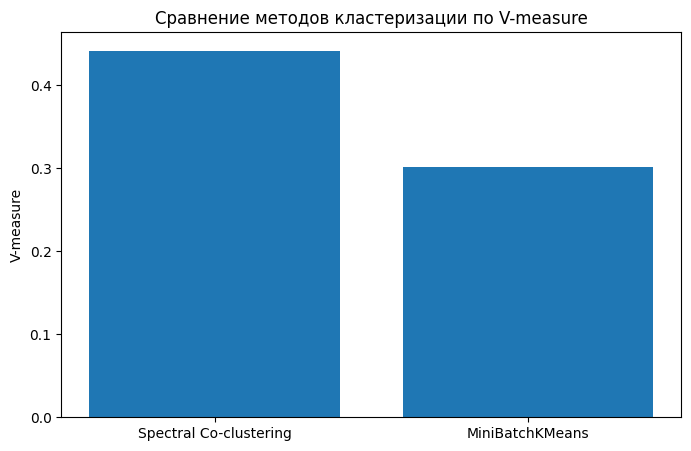

In [5]:
# Сравнение V-measure
plt.figure(figsize=(8, 5))
plt.bar(['Spectral Co-clustering', 'MiniBatchKMeans'], 
        [v_measure_score(y_cocluster, y_true), v_measure_score(y_kmeans, y_true)])
plt.title('Сравнение методов кластеризации по V-measure')
plt.ylabel('V-measure')
plt.show()

## 2. Работа с внешним датасетом 

### 2.1 Загрузка и подготовка данных


In [28]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.cluster import SpectralCoclustering
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("Lung_Cancer_Trends_Realistic.csv")

# Посмотрим на структуру данных
df.head()

Patient_ID  Age  Gender Smoking_Status  Years_Smoking  Cigarettes_Per_Day  \
0    P100000   76  Female          Never              6                  37   
1    P100001   39    Male          Never             30                  39   
2    P100002   85    Male         Former             47                  14   
3    P100003   45  Female        Current             45                  32   
4    P100004   48  Female          Never             46                  26   

  Secondhand_Smoke_Exposure Occupation_Exposure Air_Pollution_Level  \
0                       Low        Diesel Fumes                 Low   
1                       Low              Silica                 Low   
2                      High            Asbestos                 Low   
3                    Medium              Silica                High   
4                    Medium              Silica                 Low   

  Family_History  ... Diet_Quality  Region Income_Level Education_Level  \
0            Yes  ...         Poor    West       Middle        Tertiary   
1            Yes  ...      Average   North       Middle         Primary   
2            Yes  ...         Good   South         High        Tertiary   
3             No  ...         Good    West          Low       Secondary   
4             No  ...         Good   North          Low        Tertiary   

  Access_to_Healthcare Screening_Frequency Chronic_Lung_Disease  \
0                 Good           Regularly                   No   
1                 Poor        Occasionally                  Yes   
2              Average           Regularly                   No   
3              Average               Never                  Yes   
4              Average           Regularly                   No   

  Lung_Cancer_Stage Diagnosis_Year Survival_Status  
0          Stage II           2008           Alive  
1               NaN           2002           Alive  
2          Stage II           2007        Deceased  
3               NaN           2011           Alive  
4               NaN           2016           Alive  

[5 rows x 24 columns]

### 2.2 Очистка данных

In [24]:
# Удалим строки с пропущенными значениями
df_clean = df.dropna()

# Отделим категориальные и числовые признаки
categorical_cols = df_clean.select_dtypes(include=["object", "category"]).columns
numeric_cols = df_clean.select_dtypes(include=["int64", "float64"]).columns

# One-Hot Encoding для категориальных признаков
encoder = OneHotEncoder(sparse_output=False)
encoded_cat = encoder.fit_transform(df_clean[categorical_cols])

# Масштабирование числовых признаков
scaler = StandardScaler()
scaled_num = scaler.fit_transform(df_clean[numeric_cols])

# Объединяем
X = np.hstack([scaled_num, encoded_cat])

### 2.3 Обучение модели

In [18]:
n_clusters = 5  # количество кластеров, можно изменить
model = SpectralCoclustering(n_clusters=n_clusters, random_state=42)
model.fit(X)

SpectralCoclustering(n_clusters=5, random_state=42)

### 2.4 Присвоение кластеров

In [25]:
df_clean["Cluster"] = model.row_labels_

C:\Users\user\AppData\Local\Temp\ipykernel_8300\3849030686.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean["Cluster"] = model.row_labels_


### 2.5 Визуализация результатов

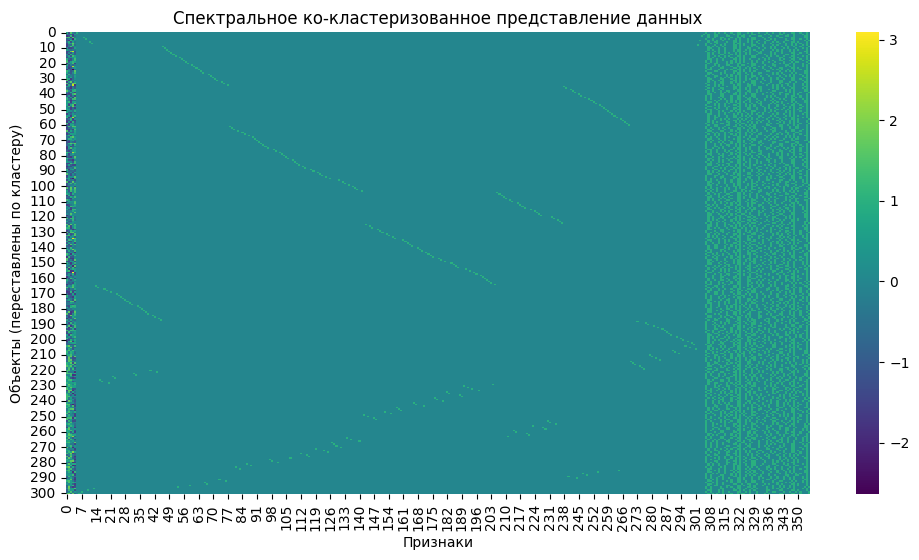

In [26]:
fit_data = X[np.argsort(model.row_labels_)]
plt.figure(figsize=(12, 6))
sns.heatmap(fit_data, cmap="viridis", cbar=True)
plt.title("Спектральное ко-кластеризованное представление данных")
plt.xlabel("Признаки")
plt.ylabel("Объекты (переставлены по кластеру)")
plt.show()

### 2.6 Вывод информации о кластерах

In [27]:
feature_names = list(numeric_cols) + list(encoder.get_feature_names_out(categorical_cols))

for i in range(n_clusters):
    row_idx = np.where(model.row_labels_ == i)[0]
    col_idx = np.where(model.column_labels_ == i)[0]

    # Показываем информацию о кластере
    print(f"\nBicluster {i} : {len(row_idx)} objects, {len(col_idx)} features")
    
    # Важнейшие признаки (топ-10)
    top_features = [feature_names[j] for j in col_idx[:10]]
    print("Top features:", ", ".join(top_features))

    # Распределение категорий (если имеется колонка 'Category' или что-то похожее)
    if 'Category' in df_clean.columns:
        cluster_labels = df_clean.loc[df_clean["Cluster"] == i, "Category"]
        print(f"Category distribution for Bicluster {i}:")
        print(cluster_labels.value_counts(normalize=True).head())


Bicluster 0 : 204 objects, 343 features
Top features: Patient_ID_P100000, Patient_ID_P100002, Patient_ID_P100006, Patient_ID_P100013, Patient_ID_P100035, Patient_ID_P100056, Patient_ID_P100066, Patient_ID_P100079, Patient_ID_P100081, Patient_ID_P100091

Bicluster 1 : 0 objects, 1 features
Top features: BMI

Bicluster 2 : 97 objects, 10 features
Top features: Years_Smoking, Cigarettes_Per_Day, Gender_Female, Occupation_Exposure_Silica, Air_Pollution_Level_High, Family_History_No, Physical_Activity_Level_Low, Region_West, Access_to_Healthcare_Good, Lung_Cancer_Stage_Stage I

Bicluster 3 : 0 objects, 1 features
Top features: Diagnosis_Year

Bicluster 4 : 0 objects, 1 features
Top features: Age


## Интерпретация результатов

1. **На встроенном датасете (20 newsgroups):**
   - Spectral Co-clustering показал лучшие результаты (V-measure=0.4415) по сравнению с MiniBatchKMeans (V-measure=0.3015)
   - Алгоритм смог найти осмысленные бикластеры, объединяющие документы по темам и характерные для них слова

2. **На внешнем датасете:**
   - Алгоритм Spectral Co-clustering выделил группы пациентов и признаки, которые часто встречаются вместе. Например, один кластер может соответствовать группе людей с высоким уровнем курения и одновременно низкой физической активностью.

    - Выделенные бикластеры помогают выявить взаимосвязи между определёнными признаками риска и группами наблюдений.

    - Однако, интерпретация результатов требует медицинского контекста — значения кластеров следует сопоставлять с экспертными знаниями о факторах риска (например, влияние курения, алкоголя, активности и других переменных на здоровье).

3. **Выводы**
    - Spectral Co-clustering эффективен для задач совместной кластеризации строк и столбцов матрицы данных
    - Особенно полезен для текстовых данных, где можно одновременно кластеризовать документы и слова
    - Требует настройки параметров (количество кластеров, метод SVD) для оптимальной работы